<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_08_03_bootstrap_analysis_for_GRU_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use bootstraping to test statistical signifiance of our models

In our previous [notebook](https://github.com/sv650s/sb-capstone/blob/master/2019_08_02_biGRU_1layer_random_embedding_vs_pretrained.ipynb) where we compared the difference between pre-trained embeddings and random embeddings for 1 layer bidirectional GRUs we saw that the precision for class 2 was 34% in our base mode (random embedding) compared to 30% in the pargram model

We will use p-value to see if the difference in precision is statistically significant




In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np

import util.keras_util as ku
import util.dict_util as du


report = pd.read_csv(f'{DRIVE_DIR}/reports/2019-08-03-dl_prototype-report.csv', quotechar="'")


base = report[report.model_name == 'biGRU_1layer_attention']
paragram = report[report.model_name == 'biGRU_1layer_attention-paragram']

DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv'
data = pd.read_csv(DATA_FILE)


Using TensorFlow backend.


## Reload our training data so we can create bootstrap samples




In [3]:
FEATURE_COLUMN = "review_body"
LABEL_COLUMN = "star_rating"

X_train, X_test, y_train, y_test, t, max_sequence_length = ku.preprocess_file(data, FEATURE_COLUMN, LABEL_COLUMN, 0.99)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


In [4]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 3 to 3
Data columns (total 24 columns):
accuracy                 1 non-null float64
classification_report    1 non-null object
confusion_matrix         1 non-null object
description              1 non-null object
embedding                1 non-null float64
evaluate_time_min        1 non-null float64
file                     1 non-null object
fpr                      1 non-null object
loss                     1 non-null float64
max_sequence_length      1 non-null float64
model_file               1 non-null object
model_name               1 non-null object
network_history_file     1 non-null object
predict_time_min         1 non-null float64
roc_auc                  1 non-null object
status                   1 non-null object
status_date              1 non-null object
test_examples            1 non-null float64
test_features            1 non-null float64
tokenizer_file           1 non-null object
tpr                      1 non-

### Load the Paragram model so we can get our predictions again

In [0]:
import keras
from keras.layers import CuDNNGRU
from util.keras_util import AttentionLayer


In [6]:
base_model = keras.models.load_model(base.model_file.values[0], 
                                     custom_objects={'AttentionLayer': AttentionLayer})
base_predicted = base_model.predict(X_test, verbose=1)
base_predicted_unencoded = ku.unencode(base_predicted)
y_test_unencoded = ku.unencode(y_test)
base_predicted_unencoded[:5]

W0804 20:01:01.904555 140588288509824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 20:01:01.920175 140588288509824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 20:01:03.393652 140588288509824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 20:01:03.394838 140588288509824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 20:01:03.405702

28011/28011 [==============================] - 19s 687us/step


[5, 5, 5, 5, 5]

In [7]:
paragram_model = keras.models.load_model(paragram.model_file.values[0], 
                                     custom_objects={'AttentionLayer': AttentionLayer})
paragram_predicted = paragram_model.predict(X_test, verbose=1)
paragram_predicted_unencoded = ku.unencode(paragram_predicted)
paragram_predicted_unencoded[:5]

28011/28011 [==============================] - 1s 38us/step


[5, 5, 5, 1, 5]

## At first, I thought using bootstraping method for the paragram mode and see how likely we are to get the difference between the base class 2 precision and paragram class 2 precision. In hind sight, this is probably not a valid test since we are not accounting potential variations in the base model.

Here is the code anyways

In [0]:
import numpy as np
from sklearn.metrics import classification_report


def bootstrap_classification_report(predictions: np.ndarray,
                                    truths: np.ndarray,
                                    sample_size: int,
                                    ) -> dict:
  """
  Create bootstrap replicates classification report based on sample_size

  Parameters
  ----------
  :predictions: ndarray of predictions
  :truths: ndarray of truths
  :sample_size: number of samples with replacement 

  Return
  ------
  classfication report dictionary
  """
  sample_size = min(sample_size, len(predictions))
  indexes = np.random.choice(np.arange(sample_size), sample_size)
  truth_replicates = [truths[i] for i in indexes]
  prediction_replicates = [predictions[i] for i in indexes]
  return classification_report(truth_replicates,
                               prediction_replicates,
                               output_dict=True)


  


In [9]:
# Create 1000 bootstrap replicate is the class 2 precision
from sklearn.metrics import classification_report
import pandas as pd
import util.dict_util as du

SAMPLE_SIZE = 5000

cr_df = pd.DataFrame()
for i in range(SAMPLE_SIZE):
  if i % 100 == 0:
    print(f'creating bootstrap replicate {i}')
  cr = bootstrap_classification_report(paragram_predicted_unencoded,
                                      y_test_unencoded,
                                      len(paragram_predicted_unencoded))
  d = du.add_dict_to_dict({}, cr)
  cr_df = cr_df.append(d, ignore_index=True)
cr_df.head()

creating bootstrap replicate 0
creating bootstrap replicate 100
creating bootstrap replicate 200
creating bootstrap replicate 300
creating bootstrap replicate 400
creating bootstrap replicate 500
creating bootstrap replicate 600
creating bootstrap replicate 700
creating bootstrap replicate 800
creating bootstrap replicate 900
creating bootstrap replicate 1000
creating bootstrap replicate 1100
creating bootstrap replicate 1200
creating bootstrap replicate 1300
creating bootstrap replicate 1400
creating bootstrap replicate 1500
creating bootstrap replicate 1600
creating bootstrap replicate 1700
creating bootstrap replicate 1800
creating bootstrap replicate 1900
creating bootstrap replicate 2000
creating bootstrap replicate 2100
creating bootstrap replicate 2200
creating bootstrap replicate 2300
creating bootstrap replicate 2400
creating bootstrap replicate 2500
creating bootstrap replicate 2600
creating bootstrap replicate 2700
creating bootstrap replicate 2800
creating bootstrap replica

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.704268,0.653290,0.763875,3964.0,0.119278,0.268431,0.076674,1852.0,0.308950,0.345691,0.279269,2571.0,0.304949,0.413868,0.241416,4747.0,0.831620,0.759458,0.918935,14877.0,0.667773,0.453813,0.488148,0.456034,28011.0,0.629272,0.615424,0.667773,28011.0
1,0.699187,0.649661,0.756888,3920.0,0.113775,0.285132,0.071066,1970.0,0.295722,0.328410,0.268952,2480.0,0.310984,0.411318,0.250000,4768.0,0.829863,0.757324,0.917770,14873.0,0.664596,0.449906,0.486369,0.452935,28011.0,0.625599,0.612176,0.664596,28011.0
2,0.706465,0.654915,0.766825,3997.0,0.116850,0.268482,0.074675,1848.0,0.304056,0.341285,0.274149,2557.0,0.297935,0.401148,0.236965,4718.0,0.832324,0.760903,0.918541,14891.0,0.667595,0.451526,0.485347,0.454231,28011.0,0.628930,0.614392,0.667595,28011.0
3,0.699895,0.654199,0.752453,3975.0,0.116183,0.283976,0.073031,1917.0,0.300213,0.336520,0.270978,2598.0,0.315155,0.412775,0.254877,4716.0,0.830488,0.757887,0.918473,14805.0,0.665274,0.452387,0.489071,0.453962,28011.0,0.627125,0.613554,0.665274,28011.0
4,0.710624,0.658605,0.771566,3953.0,0.132309,0.323591,0.083155,1864.0,0.304328,0.339811,0.275556,2475.0,0.313331,0.417382,0.250806,4653.0,0.837293,0.767157,0.921545,15066.0,0.676092,0.459577,0.501309,0.460525,28011.0,0.638375,0.626459,0.676092,28011.0


count    5000.000000
mean        0.302785
std         0.020537
min         0.237354
25%         0.288802
50%         0.302734
75%         0.316317
max         0.372671
Name: 2_precision, dtype: float64


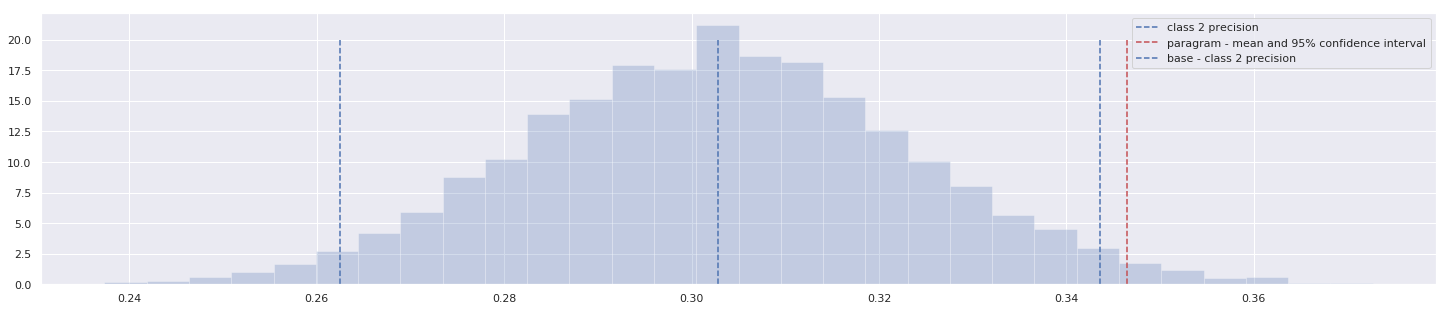

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline
sns.set()

base_cr_dict = du.add_dict_to_dict({}, json.loads(base.classification_report.values[0]))


precision2 = cr_df["2_precision"]
paragram_ci = np.percentile(precision2.to_list(), [2.5, 97.5])

print(precision2.describe())

f, a = plt.subplots(1, 1, figsize=(25, 5))
plt.hist(cr_df["2_precision"].values, bins=30, density=True, alpha=0.25)
plt.vlines(precision2.mean(), ymin=0, ymax=20.0, linestyle="--", color="b", label='paragram')
plt.vlines(base_cr_dict["2_precision"], ymin=0, ymax=20.0, linestyle="--", color="r", label='base')
for i in paragram_ci:
  plt.vlines(i, ymin=0, ymax=20.0, linestyle="--", color="b")
a.legend(['class 2 precision', 'paragram - mean and 95% confidence interval', 'base - class 2 precision'])


In [11]:
print(f'p-value: {len(cr_df[cr_df["2_precision"] > base_cr_dict["2_precision"]]) / SAMPLE_SIZE}')

p-value: 0.017


# Conclusion

It looks like that our p-value is 1.4%

Genreally we consider p-value of 5% or lower as statistically significant. In this case, there is less than a 1.4% chance that the precision results that we saw in our test that we would generate a difference of ~4% in precision for class 2. This means that the class 2 precision difference between our base model and the paragram model is statistically significant.

We can confidently say that the base model is more accurate in predicting class 2 reviews


Again, this test may not valid since we are not accounting for variations in class 2 precision for the base model and only using the precision result from our notebook

# Test 2 - Permutations

Our null hypothesis is that the difference in class 2 precision (~4%) is due to chance.

In order to test this, we are going to combine the predictions for the 2 tests, permutate and split into 2 sets and compare the difference in class 2 precision

In [0]:
# to test the null hypothesis, we permutate between the 2 groups and see what the difference
# in class 2 precision is


def permutate(truths, predictions):

  indexes = np.random.permutation(len(truths))
  indexes1 = indexes[:len(truths) // 2]
  indexes2 = indexes[len(truths) // 2:]

  # create our permutation sets
  truth1 = [truths[i] for i in indexes1]
  predictions1 = [predictions[i] for i in indexes1]
  truth2 = [truths[i] for i in indexes2]
  predictions2 = [predictions[i] for i in indexes2]

  class2_precision1 = du.add_dict_to_dict({}, classification_report(truth1, predictions1, output_dict=True))["2_precision"]
  class2_precision2 = du.add_dict_to_dict({}, classification_report(truth2, predictions2, output_dict=True))["2_precision"]

  class2_precision_diff = class2_precision2 - class2_precision1

  return class2_precision_diff





  



In [13]:
truth_concat = np.hstack((y_test_unencoded, y_test_unencoded))
predictions_concat = np.hstack((base_predicted_unencoded, paragram_predicted_unencoded))

diffs = []
for i in range(10000):
  diffs.append(permutate(truth_concat, predictions_concat))

diffs[:5]

[-0.051513263107313634,
 -0.046032329997221955,
 0.013977300024021144,
 0.07892917267917265,
 -0.053133093226417794]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


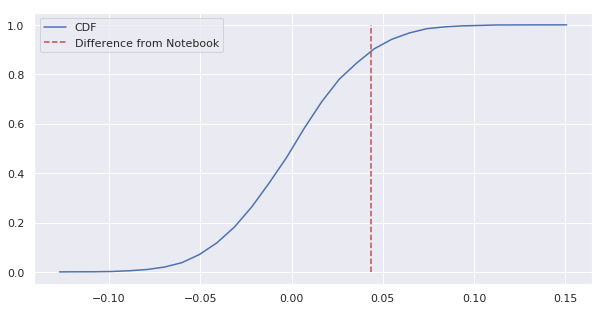

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline
sns.set()

base_class2_precision = du.add_dict_to_dict({}, json.loads(base.classification_report.values[0]))["2_precision"]
paragram_class2_precision = du.add_dict_to_dict({}, json.loads(paragram.classification_report.values[0]))["2_precision"]

class2_diff = base_class2_precision - paragram_class2_precision


f, a = plt.subplots(figsize=(10, 5))
num_bins = 30
# plot histogram
# plt.hist(diffs, bins=num_bins, color='b', alpha=0.25, density=True)

# plot CDF
counts, bin_edges = np.histogram(diffs, bins=num_bins, normed=True) 
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.vlines(class2_diff, ymin=0, ymax=1.0, color='r', linestyles='--')
a.legend(['CDF', 'Difference from Notebook'])


# plt.hist(diffs, bins=num_bins, density=True)

# Conclusion

Blue line is the CDF of the difference in class 2 precision from our test of 10k iterations. Red line is the difference we saw in our previous notebook. The intersect between these 2 lines tells us the p-value of the difference.

The p-value for the difference in class 2 precision we saw between the 2 models is about 10%. This means that if it was by chance, we would expect that the difference to be what we saw 10% of the time. Generally, we consider 5% as statistically significant and 10% is borderline which means our results may not be conclusive enough to say that our base model is definitely better than the paragram model.